<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB
Best Score of  DecisionTree is : 0.7307692307692307 with the random_state: 21

 Report of the Model:  DecisionTree 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.93      0.96        14

    accuracy                           0.96        26
   macro avg       0.96      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26
 

Best Score of  LogisticReg is : 0.6923076923076923 with the random_state: 10

 Report of the Mode

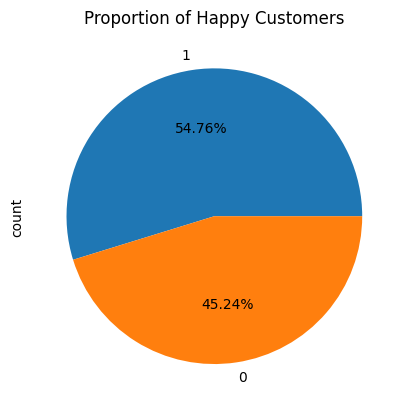

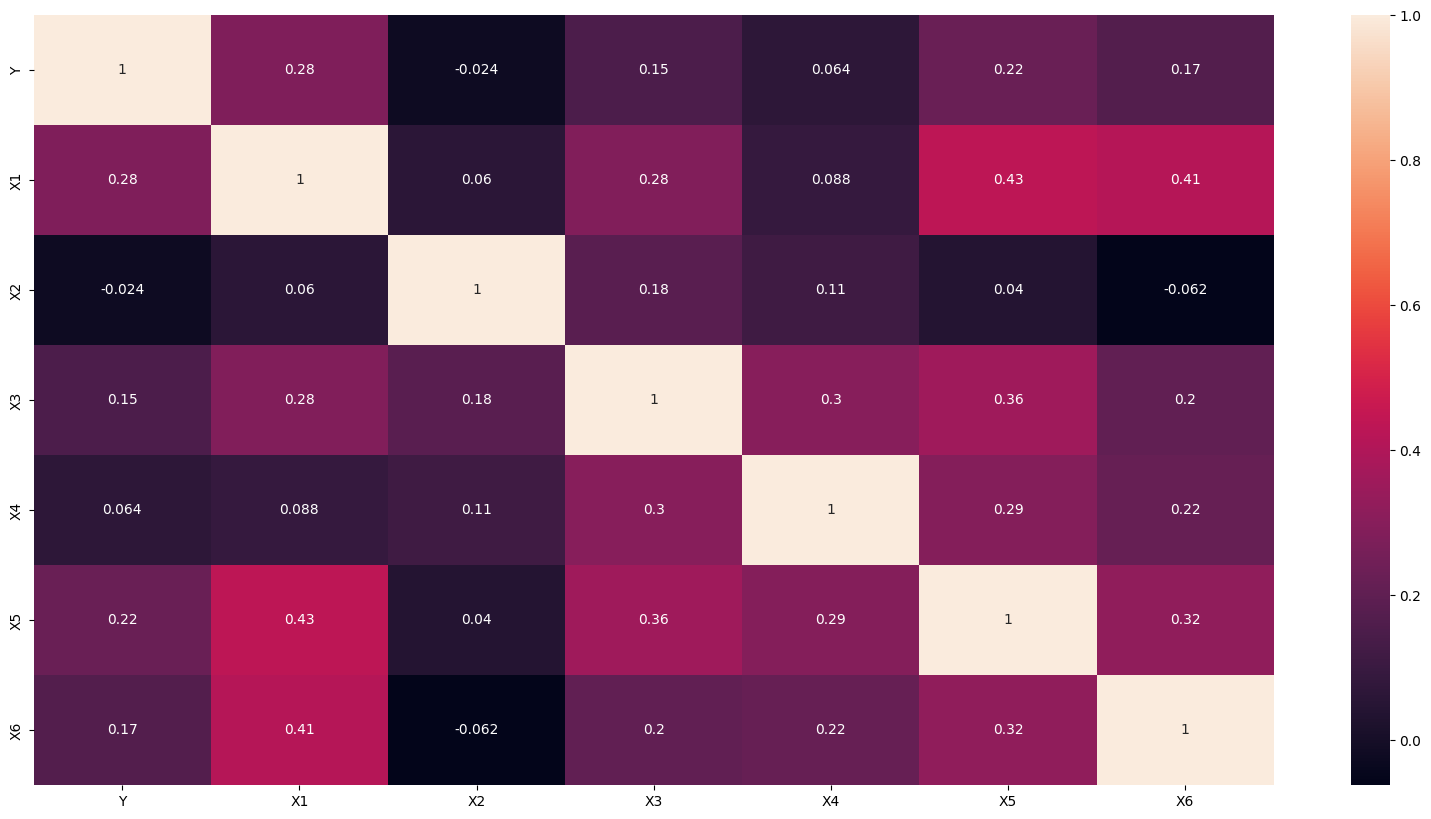

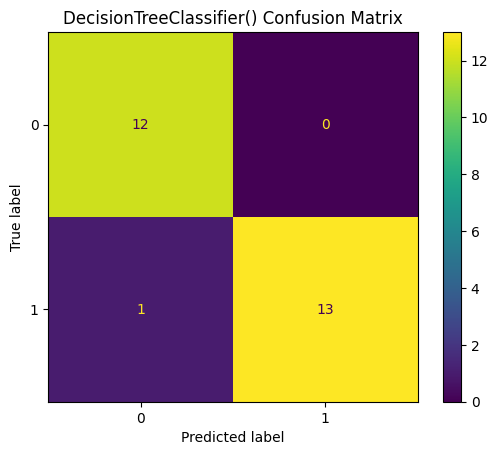

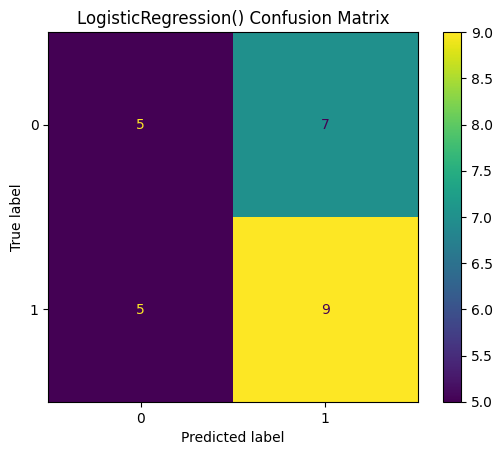

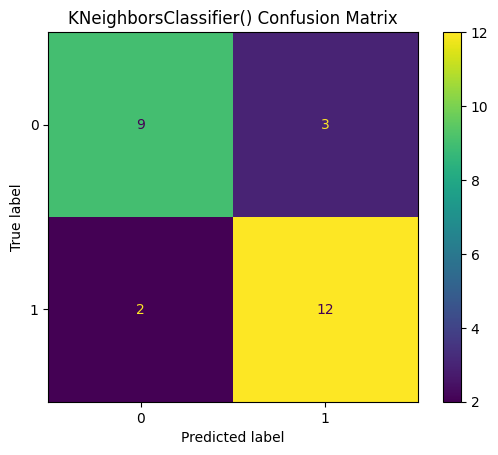

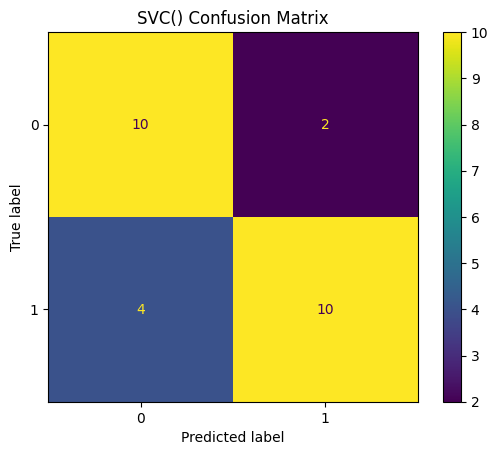

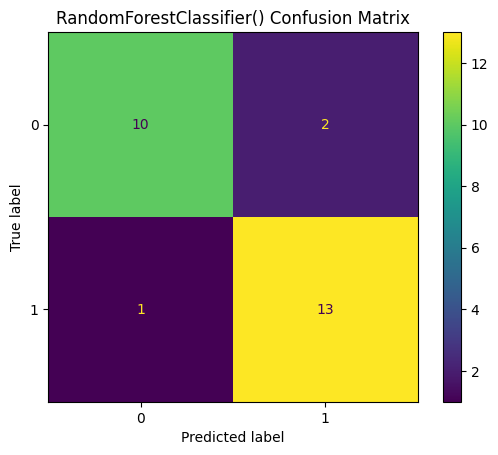

Best Score of  DecisionTree is : 0.8076923076923077 with the random_state: 8

 Report of the Model:  DecisionTree 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.79      0.79      0.79        14

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26
 

Best Score of  LogisticReg is : 0.7307692307692307 with the random_state: 45

 Report of the Model:  LogisticReg 
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.57      0.57      0.57        14

    accuracy                           0.54        26
   macro avg       0.54      0.54      0.54        26
weighted avg       0.54      0.54      0.54        26
 

Best Score of  KNN is : 0.7692307692307693 with the random_state: 34

 Report of the Model:  KNN 
             

In [37]:
#Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#loading the data
happy=pd.read_csv('ACME-HappinessSurvey2020.csv')
happy.head()

happy.shape

happy.info()

#See columns in data
happy.columns

happy.describe()

happy.isnull().sum() #There are no null variables, all numerical data

#Data Exploration

#Visualisation of target column relative frequency
happy['Y'].value_counts().plot(kind='pie',autopct='%1.2f%%',title='Proportion of Happy Customers')
#Data is not completely unbalanced

#Correlation between variables
plt.figure(figsize=(20,10))
sns.heatmap(happy.corr(),annot=True)
happy.corr() #No multicollinearity

#Data Modeling

#Importing Logistic Regression model
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression(random_state=0, solver="liblinear")

#Importing "train_test-split" function to test the model
from sklearn.model_selection import train_test_split

#Splitting the data
X=happy.drop(['Y'],axis=1)
y=happy['Y']

#Model Comparison
# Compare classification algorithms
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (f1_score, accuracy_score, 
                             recall_score, 
                             precision_score, 
                             confusion_matrix, 
                             roc_auc_score, 
                             ConfusionMatrixDisplay, 
                             classification_report, 
                             precision_recall_curve)

def load_model(name):
    if name=='DecisionTree':
        model=DecisionTreeClassifier()
    elif name=='LogisticReg':
        model=LogisticRegression()
    elif name=='KNN':
        model=KNeighborsClassifier()
    elif name=="SVC":
        model=SVC()
    elif name=='RandForest':
        model=RandomForestClassifier()
    return model

models=['DecisionTree', 'LogisticReg', 'KNN', 'SVC', 'RandForest']
dict_models=dict()
dict_models.fromkeys(models)

np.random.seed(0) #makes random numbers predictable, so that results are the same everytime
for model in models:
    L=[]
    for i in range(0,50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        model1 =load_model(model)
        model1.fit(X_train,y_train)
        score_train=model1.score(X_train,y_train)
        score_test=model1.score(X_test,y_test)
        L.append(score_test)
        if score_test >= max(L):
            model_max=model1
    dict_models[model]=model_max
    print("Best Score of ",model,"is :",max(L),"with the random_state:",L.index(max(L)))
    y_pred = dict_models[model].predict(X_test)
    print("\n Report of the Model: ", model,"\n", classification_report(y_test, y_pred),"\n")

    #Random Forest with a score of 0.769 with accuracy of 0.88, precision of 0.87 and Decision Tree with a score of 0.73 with accuracy of 0.96 and prcision 1.

#Confusion Matrix for each model
for model in models:
    cf_matrix=ConfusionMatrixDisplay.from_estimator(dict_models[model], X_test, y_test)  
    plt.title(str(dict_models[model])+' Confusion Matrix')
    plt.show()
#Confusion matrix is best for Decision Tree model

#FEATURE SELECTION by feature importance

#Chisquare test for categorical feature

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#select 3 best features
chi2_features = SelectKBest(chi2, k=3)
X_kbest = chi2_features.fit_transform(X,y)
chi2_features.get_support()
selected_feat=X.columns[(chi2_features.get_support())]
selected_feat

#Most relevant features are X1, X3 and X5, we will run the models again with these three features

Xnew=happy[['X1','X3','X5']]

np.random.seed(0) #makes random numbers predictable, so that results are the same everytime
for model in models:
    L=[]
    for i in range(0,50):
        Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(Xnew, y, test_size=0.2, random_state=i)
        model1 =load_model(model)
        model1.fit(Xnew_train,ynew_train)
        score_train=model1.score(Xnew_train,ynew_train)
        score_test=model1.score(Xnew_test,ynew_test)
        L.append(score_test)
        if score_test >= max(L):
            model_max=model1
    dict_models[model]=model_max
    print("Best Score of ",model,"is :",max(L),"with the random_state:",L.index(max(L)))
    ynew_pred = dict_models[model].predict(Xnew_test)
    print("\n Report of the Model: ", model,"\n", classification_report(ynew_test, ynew_pred),"\n")